In [1]:
from astropy import conf as config
from astropy import units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS
from astropy.coordinates import SkyCoord
from astropy.table import QTable, vstack,join
from astropy.time import Time
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import plot_utils as pu

backgroundcolour = "#171726"
foregroundcolour = "#FFF"

cmap = LinearSegmentedColormap.from_list("sky", [backgroundcolour, foregroundcolour])

Simbad.clear_cache()
Simbad.reset_votable_fields()

generic_maximum_magnitude = 10

## User Inputs

In [2]:
location = "Toronto"
observation_point = (
    35*u.deg,
    140*u.deg
)  # altitude (deg from horizon), azimuth (eastwards from north)
utc_conversion = -4 * u.hour
datetime = Time("2025-02-18 19:00:00") - utc_conversion

view_radius = 20*u.deg
maximum_magnitude = 3

image_pixels = 100

## Convert Observing Point to RA/Dec

In [3]:
# query to a lat/long
earth_location = EarthLocation.of_address(location)

# generate a coordinate frame for the observation
earth_frame = AltAz(
    obstime=datetime,
    az=observation_point[1],
    alt=observation_point[0],
    location=earth_location,
)

# perform the conversion
ra_dec = earth_frame.transform_to(ICRS())

## Query SIMBAD to get a catalogue of objects with relevant data

In [4]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields("otype", "flux")
criteria = f"otype != 'err' AND flux < {generic_maximum_magnitude}"
query_result = QTable(Simbad.query_region(ra_dec, radius=view_radius, criteria=criteria))

# clean up the result
columns_to_remove = [
    "coo_err_min",
    "coo_err_angle",
    "coo_wavelength",
    "coo_bibcode",
    "coo_err_maj",
    "bibcode",
    "flux_err",
    "flux_err_prec",
    "flux_prec",
    "qual",
]
for colname in columns_to_remove:
    query_result.remove_column(colname)

# rename columns
query_result.rename_column("otype", "object_type")
query_result.rename_column("main_id", "id")
query_result.rename_columns(("filter", "flux"), ("magnitude.filter", "magnitude"))

# round columns
query_result["ra"] = query_result["ra"].round(5)
query_result["dec"] = query_result["dec"].round(5)

## Filter data

In [5]:
# only keep items with magnitudes measured in visible
query_result = query_result[query_result['magnitude.filter'] == "V"]

# only keep items with magnitudes less than the given maximum
query_result = query_result[query_result['magnitude'] < maximum_magnitude]

## Initialize image

In [6]:
wcs = WCS(naxis=2)
wcs.wcs.crpix = [image_pixels / 2]*2

degrees_per_pixel = (view_radius/(image_pixels/2)).to(u.deg).value
wcs.wcs.cdelt = [degrees_per_pixel, degrees_per_pixel]
wcs.wcs.crval = [ra_dec.ra.value, ra_dec.dec.value]
wcs.wcs.ctype = ["RA", "DEC"]
wcs.wcs.cunit = [u.deg, u.deg]

image = np.zeros((image_pixels, image_pixels))

## Add stars to image

In [7]:
for ra,dec in query_result[['ra', 'dec']]:
    skycoord = SkyCoord(ra=ra, dec=dec)
    x,y = np.round(skycoord.to_pixel(wcs)).astype(int)
    image[y,x] = 1

## Plot result

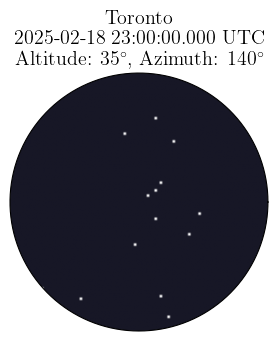

/home/taiwithers/projects/skysim/mvp/SkySim.png saved.


In [ ]:
fig, ax = pu.fig_setup(wcs=wcs, plot_kwargs={'frame_class':EllipticalFrame})

im = ax.imshow(image, cmap=cmap)

pu.style_wcs_axes(ax, axis_ticks=(False,False))

ax.invert_xaxis()

location_string = f'{location}'
datetime_string = f'{datetime} UTC'
altaz_string = f"Altitude: {observation_point[0].to_string(format="latex")}, Azimuth: {observation_point[1].to_string(format="latex")}"
ax.set_title(f'{location_string}\n{datetime_string}\n{altaz_string}')

plt.show()

pu.save_fig(fig, 'SkySim')